# 深度学习计算
:label:`chap_computation`

除了庞大的数据集和强大的硬件，
优秀的软件工具在深度学习的快速发展中发挥了不可或缺的作用。
从2007年发布的开创性的Theano库开始，
灵活的开源工具使研究人员能够快速开发模型原型，
避免了我们使用标准组件时的重复工作，
同时仍然保持了我们进行底层修改的能力。
随着时间的推移，深度学习库已经演变成提供越来越粗糙的抽象。
就像半导体设计师从指定晶体管到逻辑电路再到编写代码一样，
神经网络研究人员已经从考虑单个人工神经元的行为转变为从层的角度构思网络，
通常在设计架构时考虑的是更粗糙的块（block）。

之前我们已经介绍了一些基本的机器学习概念，
并慢慢介绍了功能齐全的深度学习模型。
在上一章中，我们从零开始实现了多层感知机的每个组件，
然后展示了如何利用高级API轻松地实现相同的模型。
为了易于学习，我们调用了深度学习库，但是跳过了它们工作的细节。
在本章中，我们将深入探索深度学习计算的关键组件，
即模型构建、参数访问与初始化、设计自定义层和块、将模型读写到磁盘，
以及利用GPU实现显著的加速。
这些知识将使你从深度学习“基础用户”变为“高级用户”。
虽然本章不介绍任何新的模型或数据集，
但后面的高级模型章节在很大程度上依赖于本章的知识。

:begin_tab:toc
 - [model-construction](model-construction.ipynb)
 - [parameters](parameters.ipynb)
 - [deferred-init](deferred-init.ipynb)
 - [custom-layer](custom-layer.ipynb)
 - [read-write](read-write.ipynb)
 - [use-gpu](use-gpu.ipynb)
:end_tab:


# 5.1层和块
:label:`sec_model_construction`

之前首次介绍神经网络时，我们关注的是具有单一输出的线性模型。
在这里，整个模型只有一个输出。
注意，单个神经网络
（1）接受一些输入；
（2）生成相应的标量输出；
（3）具有一组相关 *参数*（parameters），更新这些参数可以优化某目标函数。

然后，当考虑具有多个输出的网络时，
我们利用矢量化算法来描述整层神经元。
像单个神经元一样，层
（1）接受一组输入，
（2）生成相应的输出，
（3）由一组可调整参数描述。
当我们使用softmax回归时，一个单层本身就是模型。
然而，即使我们随后引入了多层感知机，我们仍然可以认为该模型保留了上面所说的基本架构。

对于多层感知机而言，整个模型及其组成层都是这种架构。
整个模型接受原始输入（特征），生成输出（预测），
并包含一些参数（所有组成层的参数集合）。
同样，每个单独的层接收输入（由前一层提供），
生成输出（到下一层的输入），并且具有一组可调参数，
这些参数根据从下一层反向传播的信号进行更新。

事实证明，研究讨论“比单个层大”但“比整个模型小”的组件更有价值。
例如，在计算机视觉中广泛流行的ResNet-152架构就有数百层，
这些层是由*层组*（groups of layers）的重复模式组成。
这个ResNet架构赢得了2015年ImageNet和COCO计算机视觉比赛
的识别和检测任务 :cite:`He.Zhang.Ren.ea.2016`。
目前ResNet架构仍然是许多视觉任务的首选架构。
在其他的领域，如自然语言处理和语音，
层组以各种重复模式排列的类似架构现在也是普遍存在。

为了实现这些复杂的网络，我们引入了神经网络*块*的概念。
*块*（block）可以描述**单个层、由多个层组成的组件或整个模型本身。
使用块进行抽象的一个好处是可以将一些块组合成更大的组件，
这一过程通常是递归的**，如 :numref:`fig_blocks`所示。
通过定义代码来按需生成任意复杂度的块，
我们可以通过简洁的代码实现复杂的神经网络。
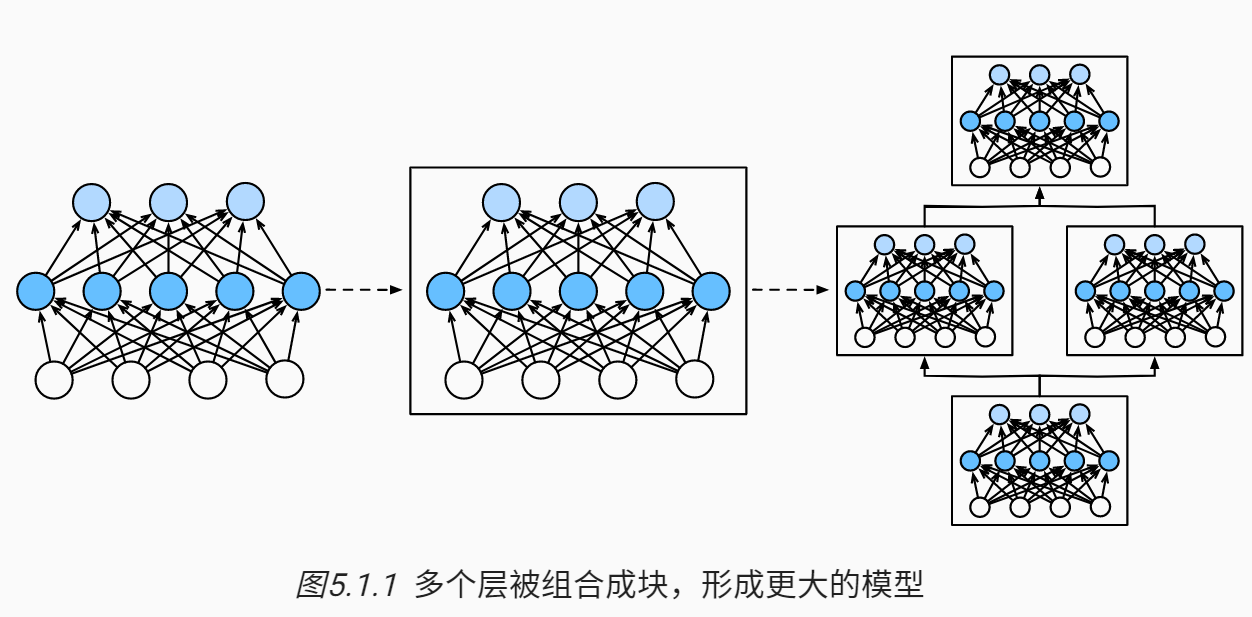
![多个层被组合成块，形成更大的模型]

:label:`fig_blocks`

从编程的角度来看，块由*类*（class）表示。
它的任何子类都必须定义一个将其输入转换为输出的前向传播函数，
并且必须存储任何必需的参数。
注意，有些块不需要任何参数。
最后，为了计算梯度，块必须具有反向传播函数。
在定义我们自己的块时，**由于自动微分（在 :numref:`sec_autograd` 中引入）
提供了一些后端实现，我们只需要考虑前向传播函数和必需的参数**。

在构造自定义块之前，(**我们先回顾一下多层感知机**)
（4.3节）的代码。
下面的代码生成一个网络，**其中包含一个具有256个单元和ReLU激活函数的全连接隐藏层，
然后是一个具有10个隐藏单元且不带激活函数的全连接输出层**。

## 递归的简单介绍
程序调用自身的编程技巧称为递归（ recursion）。递归作为一种算法在程序设计语言中广泛应用。 一个过程或函数在其定义或说明中有直接或间接调用自身的一种方法，它通常把一个大型复杂的问题层层转化为一个与原问题相似的规模较小的问题来求解，递归策略只需少量的程序就可描述出解题过程所需要的多次重复计算，大大地减少了程序的代码量。递归的能力在于用有限的语句来定义对象的无限集合。一般来说，递归需要有边界条件、递归前进段和递归返回段。当边界条件不满足时，递归前进；当边界条件满足时，递归返回。
https://blog.csdn.net/qq_29468639/article/details/119574919


In [10]:
import torch
from torch import nn#从torch包会面导入了nn模块
#从torch.nn模块里面导入例如funtional模块，该模块里定义了很多函数,比如说激活函数
from torch.nn import functional as F 
#这里定义了一个模型变量net ,这是Sequential类的实例 Sequential类将多个层串联在一起。
#当给定输入数据时，Sequential实例将数据传入到第一层， 然后将第一层的输出作为第二层的输入，以此类推。😊

#将两个参数传递到nn.Linear中，第一个的输入特征形状，第二个指定输出特征形状，nn.linear()时表示仿射变换，是一个函数
net=nn.Sequential(nn.Linear(20,256),nn.ReLU(),nn.Linear(256,10))
#输入层数是20，领用仿射变换，之后再加上激活函数到隐藏层，隐藏层是256，隐藏层的输出作为第二层的输入，也是256，最后利用仿射变换（线性神经网络）得到长度为10的输出
x=torch.randn(2,20)#生成服从标准正态分布的2*20的矩阵
net(x)


tensor([[ 0.0477, -0.1889, -0.1600,  0.0945,  0.0192,  0.0075, -0.1363,  0.0033,
         -0.3203,  0.1593],
        [ 0.1071,  0.1889, -0.2252, -0.1586, -0.1750, -0.0572,  0.0096, -0.1683,
         -0.2780,  0.0567]], grad_fn=<AddmmBackward0>)

在这个例子中，我们通过实例化nn.Sequential来构建我们的模型， 层的执行顺序是作为参数传递的。 简而言之，nn.Sequential定义了一种特殊的Module， 即在PyTorch中表示一个块的类， 它维护了一个由Module组成的有序列表。 注意，两个全连接层都是Linear类的实例， Linear类本身就是Module的子类。 另外，到目前为止，我们一直在通过net(X)调用我们的模型来获得模型的输出。 这实际上是net.__call__(X)的简写。 这个前向传播函数非常简单： 它将列表中的每个块连接在一起，将每个块的输出作为下一个块的输入。
#### nn.Sequential详细解释
https://blog.csdn.net/dss_dssssd/article/details/82980222

## 5.1.1.自定义块
要想直观地了解块是如何工作的，最简单的方法就是自己实现一个。 在实现我们自定义块之前，我们简要总结一下每个块必须提供的基本功能：
1. 将输入数据作为其前向传播函数的参数。
1. 通过前向传播函数来生成输出。请注意，输出的形状可能与输入的形状不同。例如，我们上面模型中的第一个全连接的层接收一个20维的输入，但是返回一个维度为256的输出。
1. 计算其输出关于输入的梯度，可通过其反向传播函数进行访问。通常这是自动发生的。
1. 存储和访问前向传播计算所需的参数。
1. 根据需要初始化模型参数。

在下面的代码片段中，我们从零开始编写一个块。
它包含一个多层感知机，其具有256个隐藏单元的隐藏层和一个10维输出层。
注意，下面的`MLP`类继承了表示块的类。
我们的实现只需要提供我们自己的构造函数（Python中的`__init__`函数）和前向传播函数。


In [13]:
class MLP(nn.Module):#定义了一个MLP类它的父类是nn.Module
    #用模型参数声明层。这里，我们生命两个全连接层
    def __init__(self):
        # 调用MLP的父类Module的构造函数来执行必要的初始化。
        # 这样，在类实例化时也可以指定其他函数参数，例如模型参数params（稍后将介绍）
        super().__init__()#继承父类的__init__函数，可以省去重复编写代码的痛苦
        self.hidden =nn.Linear(20,256)#隐藏层是全连接层，第一层，20个输入，256个输出
        self.out=nn.Linear(256,10)#输出层是全连接层，得二层，256个输入，10个输出
    #定义模型的向前传播，也就是如何根据输入返回所需的模型输出
    def forward(self,x):
        # 注意，这里我们使用ReLU的函数版本，其在nn.functional模块中定义。
        return self.out(F.relu(self.hidden(x)))
        

我们首先看一下前向传播函数，它以`X`作为输入，
计算带有激活函数的隐藏表示，并输出其未规范化的输出值。
在这个`MLP`实现中，两个层都是实例变量。
要了解这为什么是合理的，可以想象实例化两个多层感知机（`net1`和`net2`），
并根据不同的数据对它们进行训练。
当然，我们希望它们学到两种不同的模型。

接着我们[**实例化多层感知机的层，然后在每次调用前向传播函数时调用这些层**]。
注意一些关键细节：
首先，我们定制的`__init__`函数通过`super().__init__()`
调用父类的`__init__`函数，
省去了重复编写模版代码的痛苦。
然后，我们实例化两个全连接层，
分别为`self.hidden`和`self.out`。
注意，除非我们实现一个新的运算符，
否则我们不必担心反向传播函数或参数初始化，
系统将自动生成这些。

我们来试一下这个函数：

In [14]:
net=MLP()#创建一个对象
net(x)#实例化

tensor([[-0.2830, -0.1026,  0.0729,  0.0196,  0.3545, -0.1354, -0.2970, -0.2924,
          0.2729, -0.0352],
        [-0.1645,  0.1124, -0.0533, -0.1759, -0.0365,  0.2231,  0.1994,  0.3312,
         -0.0373,  0.2076]], grad_fn=<AddmmBackward0>)

块的一个主要优点是它的多功能性。
我们可以子类化块以创建层（如全连接层的类）、
整个模型（如上面的`MLP`类）或具有中等复杂度的各种组件。
我们在接下来的章节中充分利用了这种多功能性，
比如在处理卷积神经网络时。

## 5.1.2.顺序快

现在我们可以更仔细地看看`Sequential`类是如何工作的，
回想一下`Sequential`的设计是为了把其他模块串起来。
为了构建我们自己的简化的`MySequential`，
我们只需要定义两个关键函数：

1. 一种将块逐个追加到列表中的函数。
1. 一种前向传播函数，用于将输入按追加块的顺序传递给块组成的“链条”。

下面的`MySequential`类提供了与默认`Sequential`类相同的功能。


In [26]:
class MySequential(nn.Module):
    def __init__(self,*args):#*args是可变参数，手机参数，相当于把若干参数打包成一个来传入
        super().__init__()
        #下面的self._modules()时调用父类中__init__中的modules
        for idx,module in enumerate(args):#enumerate是一个封装函数
            #这里module是Module子类的一个实例，我们把它保存在Module类的成员
            #变量_modules中,_module类型是一个有序的字典
            self._modules[str(idx)]=module#这里表示按照字典的顺序添加
        
    def forward(self,x):
        #有序字典保证了按照成员添加的顺序遍历他们
        for block in self._modules.values():#Python 字典(Dictionary) values() 函以列表返回字典中的所有值
            x=block(x)#*args也可以是函数比如nn.Linear(),nn.ReLU，那么这样就可以实现一个一个的函数计算，前面函数的结果作为后面函数的输入
        return x

### 字典.values()介绍
ython 字典(Dictionary) values() 函以列表返回字典中的所有值

In [27]:
#!/usr/bin/python

tinydict = {'Name': 'Runoob', 'Age': 7}

print("Value : %s" %  tinydict.values())
print(tinydict)

Value : dict_values(['Runoob', 7])
{'Name': 'Runoob', 'Age': 7}


`__init__`函数将每个模块逐个添加到有序字典`_modules`中。
你可能会好奇为什么每个`Module`都有一个`_modules`属性？
以及为什么我们使用它而不是自己定义一个Python列表？
简而言之，`_modules`的主要优点是：
在模块的参数初始化过程中，
系统知道在`_modules`字典中查找需要初始化参数的子块。
当`MySequential`的前向传播函数被调用时，
每个添加的块都按照它们被添加的顺序执行。
现在可以使用我们的`MySequential`类重新实现多层感知机。


In [28]:
net=MySequential(nn.Linear(20,256),nn.ReLU(),nn.Linear(256,10))#nn.Linear(20,256),nn.ReLU(),nn.Linear(256,10)作为*args传入
net(x)

tensor([[ 0.0844,  0.2908, -0.2670, -0.4035, -0.1698, -0.1605,  0.1615,  0.2235,
         -0.3648,  0.2795],
        [ 0.1093,  0.4222, -0.1880, -0.1696,  0.0047,  0.1833,  0.1412,  0.1610,
         -0.1203,  0.1219]], grad_fn=<AddmmBackward0>)

请注意，`MySequential`的用法与之前为`Sequential`类编写的代码相同
（如 :numref:`sec_mlp_concise` 中所述）。
## 5.1.3.在向前传播函数中执行代码
`Sequential`类使模型构造变得简单，
允许我们组合新的架构，而不必定义自己的类。
然而，并不是所有的架构都是简单的顺序架构。
当需要更强的灵活性时，我们需要定义自己的块。
例如，我们可能希望在前向传播函数中执行Python的控制流。
此外，我们可能希望执行任意的数学运算，
而不是简单地依赖预定义的神经网络层。

到目前为止，
我们网络中的所有操作都对网络的激活值及网络的参数起作用。
然而，有时我们可能希望合并既不是上一层的结果也不是可更新参数的项，
我们称之为*常数参数*（constant parameter）。
例如，我们需要一个计算函数
$f(\mathbf{x},\mathbf{w}) = c \cdot \mathbf{w}^\top \mathbf{x}$的层，
其中$\mathbf{x}$是输入，
$\mathbf{w}$是参数，
$c$是某个在优化过程中没有更新的指定常量。
因此我们实现了一个`FixedHiddenMLP`类，如下所示：

In [40]:
class FixedHiddenMLP(nn.Module):
    def __init__(self):
        super().__init__()
        # 不计算梯度的随机权重参数。因此其在训练期间保持不变,也就是说我们讲requires_grad设置为False，那么后面就不会利用反向传播函数来更新权重，所以权重是一个常数
        self.randn_weight=torch.randn((20,20),requires_grad=False)
        #self.randn_weight是一个20*20的服从标准正态分布的权重
        self.linear=nn.Linear(20,20)
        #定义一个20输入20个输出的线性网络
    def forward(self,x):
        x=self.linear(x)
        #使用创建的常熟参数以及relu和mm函数
        x=F.relu(torch.mm(x,self.randn_weight)+1)#1相当于偏执
        #使用复联接层，相当于两个全量阶层共享参数
        x=self.linear(x)
        #控制流,讲x的所有制控制在很小的数，接近于零
        while x.abs().sum()>1:
            x/=2
        return x.sum()
        

在这个`FixedHiddenMLP`模型中，我们实现了一个隐藏层，
其权重（`self.rand_weight`）在实例化时被随机初始化，之后为常量。
这个权重不是一个模型参数，因此它永远不会被反向传播更新。
然后，神经网络将这个固定层的输出通过一个全连接层。

注意，在返回输出之前，模型做了一些不寻常的事情：
它运行了一个while循环，在$L_1$范数大于$1$的条件下，
将输出向量除以$2$，直到它满足条件为止。
最后，模型返回了`X`中所有项的和。
注意，此操作可能不会常用于在任何实际任务中，
我们只是向你展示如何将任意代码集成到神经网络计算的流程中。

In [41]:
net=FixedHiddenMLP()
net(x)

tensor(0.1106, grad_fn=<SumBackward0>)

我们可以[**混合搭配各种组合块的方法**]。
在下面的例子中，我们以一些想到的**方法嵌套块**。


In [42]:
class NestMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net=nn.Sequential(nn.Linear(20,64),nn.ReLU(),nn.Linear(64,32),nn.ReLU())
        self.linear=nn.Linear(32,16)
        
    def forward(self,x):
        return self.linear(self.net(x))
chimera=nn.Sequential(NestMLP(),nn.Linear(16,20),FixedHiddenMLP())
chimera(x)

tensor(0.3109, grad_fn=<SumBackward0>)

## 5.1.4.效率
你可能会开始担心操作效率的问题。
毕竟，我们在一个高性能的深度学习库中进行了大量的字典查找、
代码执行和许多其他的Python代码。
Python的问题[全局解释器锁](https://wiki.python.org/moin/GlobalInterpreterLock)
是众所周知的。
在深度学习环境中，我们担心速度极快的GPU可能要等到CPU运行Python代码后才能运行另一个作业。
## 5.1.5小结

* 一个块可以由许多层组成；一个块可以由许多块组成。
* 块可以包含代码。
* 块负责大量的内部处理，包括参数初始化和反向传播。
* 层和块的顺序连接由`Sequential`块处理。

## 5.1.6练习

1. 如果将`MySequential`中存储块的方式更改为Python列表，会出现什么样的问题？
1. 实现一个块，它以两个块为参数，例如`net1`和`net2`，并返回前向传播中两个网络的串联输出。这也被称为平行块。
1. 假设你想要连接同一网络的多个实例。实现一个函数，该函数生成同一个块的多个实例，并在此基础上构建更大的网络。


# 5.2参数管理
在选择了架构并设置了超参数后，我们就进入了训练阶段。
此时，我们的目标是找到使损失函数最小化的模型参数值。
经过训练后，我们将需要使用这些参数来做出未来的预测。
此外，有时我们希望提取参数，以便在其他环境中复用它们，
将模型保存下来，以便它可以在其他软件中执行，
或者为了获得科学的理解而进行检查。

之前的介绍中，我们只依靠深度学习框架来完成训练的工作，
而忽略了操作参数的具体细节。
本节，我们将介绍以下内容：

* 访问参数，用于调试、诊断和可视化。
* 参数初始化。
* 在不同模型组件间共享参数。

(**我们首先看一下具有单隐藏层的多层感知机。**)


In [54]:
import torch
from torch import nn
net=nn.Sequential(nn.Linear(4,8),nn.ReLU(),nn.Linear(8,1))#创建了对象
x=torch.rand(size=(2,4))#样本数为2输入参数是4
#x=torch.arange(8).reshape(2,4) 
net(x)#实例化对象


tensor([[-0.0419],
        [-0.0480]], grad_fn=<AddmmBackward0>)

## 5.2.1 参数访问
我们从已有模型中访问参数。
当通过`Sequential`类定义模型时，
我们可以通过索引来访问模型的任意层。
这就像模型是一个列表一样，每层的参数都在其属性中。
如下所示，我们可以检查第二个全连接层的参数。


In [55]:
#net[0]=nn.Linear(4,8),net[1]=nn.ReLU,net[2]=nn.Linear（8，1）
print(net[0].state_dict())#.state_dict()输出的是一个有序字典，输出的结果是该层包含的两个参数，分别是该层的权重和偏置
print(net[2].state_dict())#相当于创建对象之后实例化，,state_dict()是nn.Sequential中的一个实例方法，返回字典
print(net[1].state_dict())#net[1]是激活函数什么也没有
print(net[2])
#权重如何确定的？

OrderedDict([('weight', tensor([[ 0.4782, -0.0100,  0.2209, -0.2943],
        [-0.3055,  0.0550,  0.2825, -0.4233],
        [-0.1759,  0.4415,  0.3786, -0.0768],
        [ 0.3740,  0.4158, -0.0230, -0.3504],
        [ 0.4824, -0.2400, -0.2481,  0.0094],
        [ 0.2244,  0.0195,  0.1646,  0.4034],
        [ 0.1549,  0.0669,  0.1736, -0.4863],
        [ 0.2913, -0.3015, -0.2116, -0.3084]])), ('bias', tensor([ 0.2923,  0.3944,  0.4436,  0.2093,  0.1726, -0.1781,  0.4607,  0.3099]))])
OrderedDict([('weight', tensor([[ 0.3192, -0.0624, -0.0108, -0.1065, -0.1128,  0.1498, -0.2228, -0.2117]])), ('bias', tensor([-0.0171]))])
OrderedDict()
Linear(in_features=8, out_features=1, bias=True)


输出的结果告诉我们一些重要的事情：
首先，这个全连接层包含两个参数，分别是该层的权重和偏置。
两者都存储为单精度浮点数（float32）。
注意，参数名称允许唯一标识每个参数，即使在包含数百个层的网络中也是如此。

### [**目标参数**]

注意，每个参数都表示为参数类的一个实例。
要对参数执行任何操作，首先我们需要访问底层的数值。
有几种方法可以做到这一点。有些比较简单，而另一些则比较通用。
下面的代码从第二个全连接层（即第三个神经网络层）提取偏置，
提取后返回的是一个参数类实例，并进一步访问该参数的值。

In [56]:
print(type(net[2].bias))#<class 'torch.nn.parameter.Parameter'>结果说明是个可以优化的参数
print(net[2].bias)#是一个带有梯度的偏执,类似于x=torch.arange(8,requires_grad=True)
print(net[2].bias.data)#去掉梯度
print(net.state_dict())

<class 'torch.nn.parameter.Parameter'>
Parameter containing:
tensor([-0.0171], requires_grad=True)
tensor([-0.0171])
OrderedDict([('0.weight', tensor([[ 0.4782, -0.0100,  0.2209, -0.2943],
        [-0.3055,  0.0550,  0.2825, -0.4233],
        [-0.1759,  0.4415,  0.3786, -0.0768],
        [ 0.3740,  0.4158, -0.0230, -0.3504],
        [ 0.4824, -0.2400, -0.2481,  0.0094],
        [ 0.2244,  0.0195,  0.1646,  0.4034],
        [ 0.1549,  0.0669,  0.1736, -0.4863],
        [ 0.2913, -0.3015, -0.2116, -0.3084]])), ('0.bias', tensor([ 0.2923,  0.3944,  0.4436,  0.2093,  0.1726, -0.1781,  0.4607,  0.3099])), ('2.weight', tensor([[ 0.3192, -0.0624, -0.0108, -0.1065, -0.1128,  0.1498, -0.2228, -0.2117]])), ('2.bias', tensor([-0.0171]))])


参数是复合的对象，包含值、梯度和额外信息。
这就是我们需要显式参数值的原因。
除了值之外，我们还可以访问每个参数的梯度。
在上面这个网络中，由于我们还没有调用反向传播，所以参数的梯度处于初始状态。

In [57]:
net[2].weight.grad==None

True

### [**一次性访问所有参数**]

当我们需要对所有参数执行操作时，逐个访问它们可能会很麻烦。
当我们处理更复杂的块（例如，嵌套块）时，情况可能会变得特别复杂，
因为我们需要递归整个树来提取每个子块的参数。
下面，我们将通过演示来比较访问第一个全连接层的参数和访问所有层。

#### 那个 * *，* **的意义
https://www.geeksforgeeks.org/args-kwargs-python/

In [59]:
print([(name,param.shape) for name,param in net[0].named_parameters()])
print(type(net[0].named_parameters()))#<class 'generator'>是个迭代器
print([(name,param) for name,param in net[0].named_parameters()])#与前面的state_dict的结果一样返回的是其权重以及权重的值，但是一个迭代器
print([(name,param) for name,param in net[0].named_parameters()])
#加上*就可以一次性打印所有的结果，不加*只能打印第一个结果
print(*[(name,param.shape) for name,param in net[0].named_parameters()])

[('weight', torch.Size([8, 4])), ('bias', torch.Size([8]))]
<class 'generator'>
[('weight', Parameter containing:
tensor([[ 0.4782, -0.0100,  0.2209, -0.2943],
        [-0.3055,  0.0550,  0.2825, -0.4233],
        [-0.1759,  0.4415,  0.3786, -0.0768],
        [ 0.3740,  0.4158, -0.0230, -0.3504],
        [ 0.4824, -0.2400, -0.2481,  0.0094],
        [ 0.2244,  0.0195,  0.1646,  0.4034],
        [ 0.1549,  0.0669,  0.1736, -0.4863],
        [ 0.2913, -0.3015, -0.2116, -0.3084]], requires_grad=True)), ('bias', Parameter containing:
tensor([ 0.2923,  0.3944,  0.4436,  0.2093,  0.1726, -0.1781,  0.4607,  0.3099],
       requires_grad=True))]
[('weight', Parameter containing:
tensor([[ 0.4782, -0.0100,  0.2209, -0.2943],
        [-0.3055,  0.0550,  0.2825, -0.4233],
        [-0.1759,  0.4415,  0.3786, -0.0768],
        [ 0.3740,  0.4158, -0.0230, -0.3504],
        [ 0.4824, -0.2400, -0.2481,  0.0094],
        [ 0.2244,  0.0195,  0.1646,  0.4034],
        [ 0.1549,  0.0669,  0.1736, -0.4863]

这为我们提供了另一种访问网络参数的方式，如下所示。

In [44]:
#结果是带有梯度的向量
net.state_dict()['2.bias']#访问字典中某个元素的方法可以通过在下表中指定名称来实现
print(net.state_dict())
net.state_dict()['2.bias'].data

OrderedDict([('0.weight', tensor([[-0.1949,  0.4574,  0.2933,  0.0587],
        [-0.3409,  0.4176,  0.0896,  0.3300],
        [ 0.2749,  0.2788,  0.3649, -0.4725],
        [-0.1480, -0.4912, -0.0883, -0.3735],
        [ 0.4112, -0.2395,  0.1906, -0.1295],
        [ 0.3904,  0.3009, -0.3572, -0.3636],
        [-0.1174, -0.3765,  0.3351,  0.0822],
        [ 0.2790,  0.3044,  0.2070, -0.1271]])), ('0.bias', tensor([-0.1223, -0.2711, -0.1104,  0.0066, -0.3683,  0.4254,  0.0714,  0.0599])), ('2.weight', tensor([[ 0.2588, -0.3502, -0.3161,  0.1126,  0.3038,  0.0185, -0.3521, -0.0764]])), ('2.bias', tensor([0.0649]))])


tensor([0.0649])

### [**从嵌套块收集参数**]

让我们看看，如果我们将多个块相互嵌套，参数命名约定是如何工作的。
我们首先定义一个生成块的函数（可以说是“块工厂”），然后将这些块组合到更大的块中。

#### add_module介绍
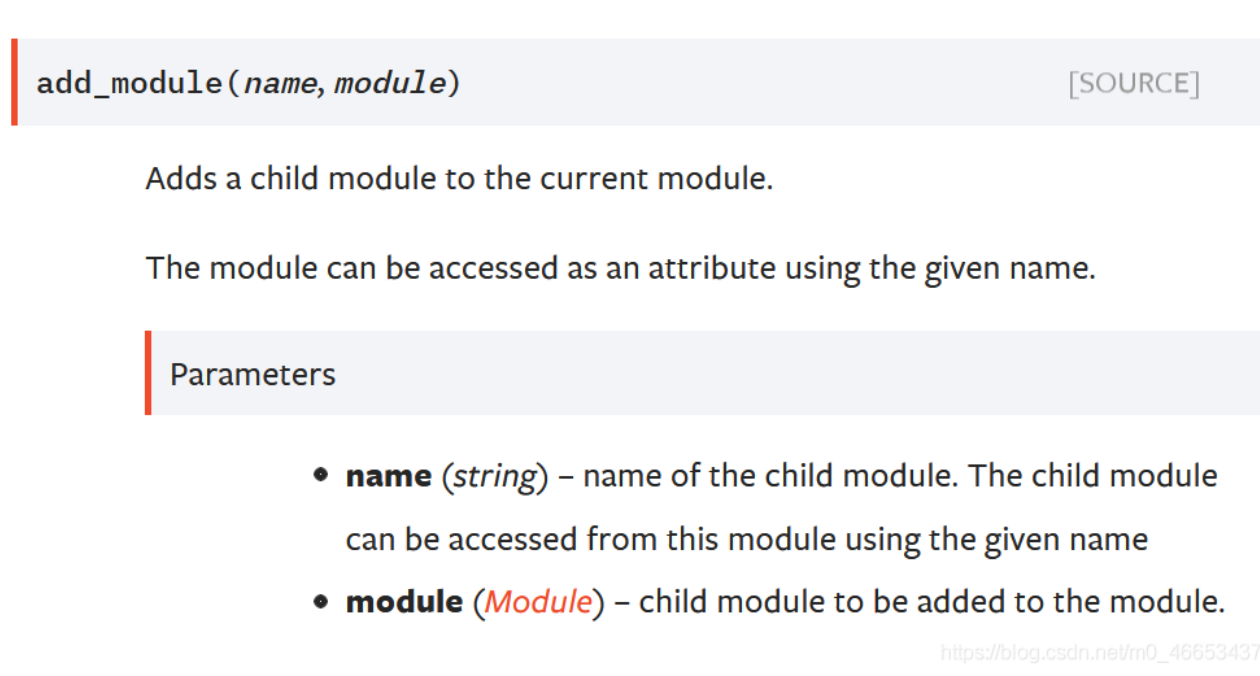
add_module(name, module)
方法: add_module(name, module)

    Adds a child module to the current module.
    
    将一个子模块添加到当前模块中.
    
    The module can be accessed as an attribute using the given name.
    通过给定的名字,我们就可以以访问属性的方式来访问该模块.
    
    Parameters  参数
    
            name (string) – name of the child module. The child
            
            module can be accessed from this module using the
            
            given name
            
			name (字符串) – 子模块的名字. 在当前模块中使用给定的这个
            name就可以访问子模块.
            
            module (Module) – child module to be added to the module.
            module (模块) – 要添加到当前模块中的子模块.

In [45]:
def block1():
    #下面定义了两个线性层
    return nn.Sequential(nn.Linear(4,8),nn.ReLU(),nn.Linear(8,4),nn.ReLU())
def block2():
    net=nn.Sequential()
    for i in range(4):
        #在这里嵌套了四个block1,总共有2*4,8层神经网络，每一层都是线性网络加激活函数
        net.add_module(f'block{i}',block1())#add_module()可以传入字符串名字以及模块，通过传入的名字来访问模块
    return net
rgnet=nn.Sequential(block2(),nn.Linear(4,1))
rgnet(x)
        

tensor([[-0.1041],
        [-0.1042]], grad_fn=<AddmmBackward0>)

[**设计了网络后，我们看看它是如何工作的。**]

In [46]:
print(rgnet)

Sequential(
  (0): Sequential(
    (block0): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block1): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block2): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block3): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
  )
  (1): Linear(in_features=4, out_features=1, bias=True)
)


因为层是分层嵌套的，所以我们也可以像通过嵌套列表索引一样访问它们。
下面，我们访问第一个主要的块中、第二个子块的第一层的偏置项。

In [47]:
rgnet[0][1][0].bias.data

tensor([ 0.1022,  0.4081, -0.3082,  0.2658,  0.1367,  0.2285, -0.1717, -0.0522])

## 参数初始化

知道了如何访问参数后，现在我们看看如何正确地初始化参数。
我们在 :numref:`sec_numerical_stability`中讨论了良好初始化的必要性。
深度学习框架提供默认随机初始化，
也允许我们创建自定义初始化方法，
满足我们通过其他规则实现初始化权

默认情况下，PyTorch会根据一个范围均匀地初始化权重和偏置矩阵，
这个范围是根据输入和输出维度计算出的。
PyTorch的`nn.init`模块提供了多种预置初始化方法。

### [**内置初始化**]

让我们首先调用内置的初始化器。
下面的代码将所有权重参数初始化为标准差为0.01的高斯随机变量，
且将偏置参数设置为0。

In [48]:
def init_normal(m):
    if type(m)==nn.Linear:#如果m的类型是线性全连接层就计算，这里加上if语句方便后面利用nn模块进行初始化
        #nn.init包里面有大量可以初始化的函数
        nn.init.normal_(m.weight,mean=0,std=0.01)#normal_是一个替换函数，表示将m.weight赋值为均值为0，方差为0.01的正态分布
        nn.init.zeros_(m.bias)#zeros_是一个替换函数，表示将m.bias赋值为0
net.apply(init_normal)
print(net)
net[0].weight.data[0],net[0].bias.data[0]
#print(type(nn.Linear))#<class 'type'>

Sequential(
  (0): Linear(in_features=4, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=1, bias=True)
)


(tensor([-0.0053,  0.0311,  0.0117, -0.0017]), tensor(0.))

### 1.net.apply()介绍
首先，我们知道**pytorch的任何网络net，都是torch.nn.Module的子类,都算是module，也就是模块。

pytorch中的model.apply(fn)会递归地将函数fn应用到父模块的每个子模块submodule，也包括model这个父模块自身。(先传递给子模块，在传递到父模块)

比如下面的网络例子中。net这个模块有两个子模块，分别为Linear(2,4)和Linear(4,8)。函数首先对Linear(2,4)和Linear(4,8)两个子模块调用init_weights函数，即print(m)打印Linear(2,4)和Linear(4,8)两个子模块。然后再对net模块进行同样的操作。如此完成递归地调用。从而完成model.apply(fn)或者net.apply(fn)。

————————————————
版权声明：本文为CSDN博主「qq_37025073」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。
原文链接：https://blog.csdn.net/qq_37025073/article/details/106739513

In [49]:
'''import torch.nn as nn
@torch.no_grad()
def init_weights(m):
    print(m)
    
net = nn.Sequential(nn.Linear(2,4), nn.Linear(4, 8))
#print(net)
#print('isinstance torch.nn.Module',isinstance(net,torch.nn.Module))
#结果
'''equential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): Linear(in_features=4, out_features=8, bias=True)
)
isinstance torch.nn.Module True'''
#print(' ')
#下面的apply（）先对nn.Linear(2,4)调用init_weights（）函数，也就是init_weights（nn.Linear(2,4)），之后
#init_weights（nn.Linear(4，8)），之后init_weights（net）依次输出结果
net.apply(init_weights)
print(nn.Linear(2,4))
print(net)'''

SyntaxError: invalid syntax (1602376373.py, line 10)

如果我们想对某些特定的子模块submodule做一些针对性的处理，该怎么做呢。我们可以加入type(m) == nn.Linear:这类判断语句，从而对子模块m进行处理。如下，读者可以细细体会一下。

可以先打印网络整体看看。调用apply函数后，先逐一打印子模块m，然后对子模块进行判断，打印Linear这类子模块m的权重。

In [50]:
'''import torch.nn as nn
@torch.no_grad()
def init_weights(m):
    print(m)
    if type(m) == nn.Linear:#
        m.weight.fill_(1.0)
        print(m.weight)
net = nn.Sequential(nn.Linear(2,4), nn.Linear(4, 8))
print(net)
print('isinstance torch.nn.Module',isinstance(net,torch.nn.Module))
print(' ')
net.apply(init_weights)'''


"import torch.nn as nn\n@torch.no_grad()\ndef init_weights(m):\n    print(m)\n    if type(m) == nn.Linear:#\n        m.weight.fill_(1.0)\n        print(m.weight)\nnet = nn.Sequential(nn.Linear(2,4), nn.Linear(4, 8))\nprint(net)\nprint('isinstance torch.nn.Module',isinstance(net,torch.nn.Module))\nprint(' ')\nnet.apply(init_weights)"

我们还可以将所有参数初始化为给定的常数，比如初始化为1。


In [51]:
def init_constant(m):
    if type(m)==nn.Linear:
        nn.init.constant_(m.weight,1)#讲m.weight用1代替，也就是赋值给1
        nn.init.zeros_(m.bias)
net.apply(init_constant)
net[0].weight.data[0],net[0].bias.data[0]

(tensor([1., 1., 1., 1.]), tensor(0.))

我们还可以[**对某些块应用不同的初始化方法**]。
例如，下面我们使用Xavier初始化方法初始化第一个神经网络层，
然后将第三个神经网络层初始化为常量值42。

In [53]:
def init_xavier(m):
    if type(m)==nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    
def init_42(m):
    if type(m)==nn.Linear:
        nn.init.constant_(m.weight,42)
#第一个线性全连接层利用nn.init.xavier_nuiform_进行随机初始化
net[0].apply(init_xavier)
#第二个线性全连接层 nn.init.constant_进行初始化，是一个全部为42的常数
net[2].apply(init_42)
#因为任何一层都是module，那么可对任何一层调用apply
print(net[0].weight.data[0])
print(net[2].weight.data[0])
print(net[0].weight.data)

tensor([ 0.3545, -0.6517,  0.0075, -0.5506])
tensor([42., 42., 42., 42., 42., 42., 42., 42.])
tensor([[ 0.3545, -0.6517,  0.0075, -0.5506],
        [ 0.6079,  0.2083,  0.4213, -0.5371],
        [-0.5650,  0.5488,  0.0565,  0.3624],
        [ 0.1169,  0.0102,  0.1478, -0.1093],
        [-0.0994, -0.5232,  0.4221, -0.2376],
        [ 0.0208, -0.7005, -0.2951,  0.2641],
        [ 0.1433,  0.5941,  0.4985, -0.1783],
        [-0.3773,  0.6909, -0.2992, -0.3552]])


###  2. Xavier
具体链接：https://blog.csdn.net/luoxuexiong/article/details/95772045

基本思想是通过网络层时，输入和输出的方差相同，包括前向传播和后向传播。具体看以下博文：

    为什么需要Xavier 初始化？
    文章第一段通过sigmoid激活函数讲述了为何初始化？
    在这里插入图片描述
    简答的说就是：

    如果初始化值很小，那么随着层数的传递，方差就会趋于0，此时输入值 也变得越来越小，在sigmoid上就是在0附近，接近于线性，失去了非线性
    如果初始值很大，那么随着层数的传递，方差会迅速增加，此时输入值变得很大，而sigmoid在大输入值写倒数趋近于0，反向传播时会遇到梯度消失的问题

其他的激活函数同样存在相同的问题。
https://prateekvjoshi.com/2016/03/29/understanding-xavier-initialization-in-deep-neural-networks/

所以论文提出，在每一层网络保证输入和输出的方差相同。


2. xavier初始化的简单推导
https://blog.csdn.net/u011534057/article/details/51673458
对于Xavier初始化方式，pytorch提供了uniform和normal两种：

    torch.nn.init.xavier_uniform_(tensor, gain=1) 均匀分布 ~ U(−a,a)

U(−a,a)
其中， a的计算公式：a=gain×6fan_in+fan_out−−−−−−−−−−−√a=gain×fan_in+fan_out6​
​
torch.nn.init.xavier_normal_(tensor, gain=1) 正态分布~N(0,std)
N(0,std)
其中std的计算公式：
std=gain×2fan_in+fan_out−−−−−−−−−−−√std=gain×fan_in+fan_out2​

### [**自定义初始化**]

有时，深度学习框架没有提供我们需要的初始化方法。
在下面的例子中，我们使用以下的分布为任意权重参数$w$定义初始化方法：

$$
\begin{aligned}
    w \sim \begin{cases}
        U(5, 10) & \text{ 可能性 } \frac{1}{4} \\
            0    & \text{ 可能性 } \frac{1}{2} \\
        U(-10, -5) & \text{ 可能性 } \frac{1}{4}
    \end{cases}
\end{aligned}
$$
同样，我们实现了一个`my_init`函数来应用到`net`。


In [63]:
def my_init(m):
    if type(m)==nn.Linear:
        print("Init",*[(name,param.shape) for name ,param in m.named_parameters()][0])
        #print("Init",*[(name,param.shape) for name ,param in m.named_parameters()])
        nn.init.uniform_(m.weight,-10,10)
        m.weight.data*=m.weight.data.abs()>=5
print("net:",net)        
net.apply(my_init)
print("net[0]:",net[0])
print("net[0].weight:",net[0].weight)
net[0].weight[:2]

net: Sequential(
  (0): Linear(in_features=4, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=1, bias=True)
)
Init weight torch.Size([8, 4])
Init weight torch.Size([1, 8])
net[0]: Linear(in_features=4, out_features=8, bias=True)
net[0].weight: Parameter containing:
tensor([[ 9.3427, -0.0000,  7.7648, -9.4037],
        [-6.1886, -0.0000, -0.0000, -5.0151],
        [-8.1124,  5.7207, -7.4275,  0.0000],
        [-9.8023,  0.0000,  7.9210, -0.0000],
        [ 9.4590,  6.5233, -6.1084, -5.8648],
        [ 6.0523, -0.0000,  9.5775, -5.0004],
        [ 5.3167,  5.5064, -9.4686,  9.9794],
        [ 0.0000,  7.9885,  0.0000, -8.9102]], requires_grad=True)


tensor([[ 9.3427, -0.0000,  7.7648, -9.4037],
        [-6.1886, -0.0000, -0.0000, -5.0151]], grad_fn=<SliceBackward0>)

注意，我们始终可以直接设置参数。

In [64]:
net[0].weight.data[:]+=1
net[0].weight.data[0,0]=42
net[0].weight.data[0]

tensor([42.0000,  1.0000,  8.7648, -8.4037])

## [**参数绑定**]

有时我们希望在多个层间共享参数：
我们可以定义一个稠密层，然后使用它的参数来设置另一个层的参数。


In [66]:
#我们需要给共享层一个名称，一边可以引用他们的参数
shared =nn.Linear(8,8)
#第二个三个隐藏层 是shared的权重，也就是说在理论上是一样的
net=nn.Sequential(nn.Linear(4,8),nn.ReLU(),
                   shared,nn.ReLU(),
                  shared,nn.ReLU(),
                  nn.Linear(8,1))
net(x)
#检查参数是否相同
print(net[2].weight.data[0]==net[4].weight.data[0])
net[2].weight.data[0, 0] = 100
# 确保它们实际上是同一个对象，而不只是有相同的值
print(net[2].weight.data[0] == net[4].weight.data[0])

tensor([True, True, True, True, True, True, True, True])
tensor([True, True, True, True, True, True, True, True])


这个例子表明第三个和第五个神经网络层的参数是绑定的。
它们不仅值相等，而且由相同的张量表示。
因此，如果我们改变其中一个参数，另一个参数也会改变。
你可能会思考：当参数绑定时，梯度会发生什么情况？
答案是由于模型参数包含梯度，因此在反向传播期间第二个隐藏层
（即第三个神经网络层）和第三个隐藏层（即第五个神经网络层）的梯度会加在一起。


## 小结

* 我们有几种方法可以访问、初始化和绑定模型参数。
* 我们可以使用自定义初始化方法。

## 练习

1. 使用 :numref:`sec_model_construction` 中定义的`FancyMLP`模型，访问各个层的参数。
1. 查看初始化模块文档以了解不同的初始化方法。
1. 构建包含共享参数层的多层感知机并对其进行训练。在训练过程中，观察模型各层的参数和梯度。
1. 为什么共享参数是个好主意？
